# Oil Price Prediction

## Constants

In [ ]:
BASE_PATH = 'PATH_TO_THE_BASE_DIRECTORY_IN_GOOGLE_DRIVE'

## Necessary codes

In [ ]:
from google.colab import drive

drive.mount('/MyDrive', force_remount=True)

Mounted at /MyDrive


In [ ]:
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.8 MB/s eta 0:00:00
time: 503 µs (started: 2024-01-07 18:20:32 +00:00)


## Imports

In [ ]:
!pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=f0eec517ecb448a451dc09fd986c67da0e6702aad4a00a8f8bfcc4ed22fb890a
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention
time: 9.56 s (started: 2024-01-07 18:20:32 +00:00)


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import copy
import random
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from keras_self_attention import SeqSelfAttention
import matplotlib

time: 7.79 ms (started: 2024-01-07 18:41:46 +00:00)


In [ ]:
sns.set()

time: 1e+03 µs (started: 2024-01-07 18:20:48 +00:00)


## Helper Functions

In [ ]:
def flatten(a):
  isChanged = None
  b = []
  while True:
    isChanged = False
    for x in a:
      try:
        b = b + list(x)
        isChanged = True
      except:
        b.append(x)
    a = b
    b = []
    if not isChanged:
      break
  return a

time: 826 µs (started: 2024-01-07 18:20:48 +00:00)


In [ ]:
def show_models_results(model, train_input, train_output, test_input, test_output, squeeze=True):
  def check_and_calc_squeeze(inp):
    if squeeze:
      return np.squeeze(inp)
    else:
      return inp

  print("train and test MAE: ",
        mean_absolute_error(train_output, model.predict(check_and_calc_squeeze(train_input), verbose=0)),
        mean_absolute_error(test_output, model.predict(check_and_calc_squeeze(test_input), verbose=0)))
  print("train and test RMSE: ",
        mean_squared_error(train_output, model.predict(check_and_calc_squeeze(train_input), verbose=0), squared=False),
        mean_squared_error(test_output, model.predict(check_and_calc_squeeze(test_input), verbose=0), squared=False))
  print("train and test MSE: ",
        mean_squared_error(train_output, model.predict(check_and_calc_squeeze(train_input), verbose=0)),
        mean_squared_error(test_output, model.predict(check_and_calc_squeeze(test_input), verbose=0)))
  print("train and test MAPE: ",
        mean_absolute_percentage_error(train_output, model.predict(check_and_calc_squeeze(train_input), verbose=0)),
        mean_absolute_percentage_error(test_output, model.predict(check_and_calc_squeeze(test_input), verbose=0)))

time: 1.61 ms (started: 2024-01-07 18:20:49 +00:00)


In [ ]:
def show_models_results_with_labels(y_true, y_pred):
  print("MAE: ",
        mean_absolute_error(y_true, y_pred))
  print("RMSE: ",
        mean_squared_error(y_true, y_pred, squared=False))
  print("MSE: ",
        mean_squared_error(y_true, y_pred))
  print("MAPE: ",
        mean_absolute_percentage_error(y_true, y_pred))

time: 1.14 ms (started: 2024-01-07 18:20:49 +00:00)


In [ ]:
import glob
import pandas as pd
import re
def get_processed_features(datasets_path, suffix):
  """
  inputs:
    suffix -> {daily, weekly, monthly} specifies the interval of features
  output:
    an array of dictionaries, each has 2 keys: {feature, featureName}
  """
  path = datasets_path + "/processed-*-" + suffix + ".csv";
  fileNames = glob.glob(path)
  features = []
  for fileName in fileNames:
    feature = (pd.read_csv(fileName))
    featureName = re.match('.*processed-(.*)-' + suffix + ".csv", fileName).group(1)
    features.append({"feature": feature, "featureName": featureName})
  return features

time: 1.11 ms (started: 2024-01-07 18:20:49 +00:00)


In [ ]:
def get_dataset(datasets_path, suffix, window_size, start_date, end_date):
  features = get_processed_features(datasets_path, suffix)

  WTI = None
  for feature in features:
    if feature["featureName"] == "WTI-price":
      WTI = feature["feature"]
      break

  WTI = WTI.rename(columns={WTI.columns[1]: "target"})

  prev_wti_target = WTI["target"][:-1]
  prev_wti_target.loc[-1] = 0
  prev_wti_target.index = prev_wti_target.index + 1
  prev_wti_target = prev_wti_target.sort_index()
  WTI["target"] = WTI["target"] - prev_wti_target

  intersection = WTI
  for feature in features:
    df = feature["feature"].rename(columns={feature["feature"].columns[1]: feature["featureName"]})
    intersection = pd.merge(df, intersection, on='Date')

  intersection = (intersection[intersection[intersection.columns[0]] >= start_date])
  intersection = (intersection[intersection[intersection.columns[0]] <= end_date]).reset_index(drop=True)

  return intersection

time: 7.5 ms (started: 2024-01-07 18:20:49 +00:00)


In [ ]:
import tensorflow as tf
import numpy as np
def get_inputs_and_outputs(df, target, window_size):
  """
  inputs:
    df -> features
    target -> target
    window_size -> window size of inputs
  output:
    [inputs: (m ,window_size, 1), outputs: (m)]
  """
  inputs = np.zeros((len(df[df.columns[0]]) - window_size, window_size, len(df.columns)))
  outputs = np.zeros((len(df[df.columns[0]]) - window_size))

  start = 0
  for i in range(window_size, len(df[df.columns[0]])):
    for idx, feature_column in enumerate(df.columns):
      inputs[start,:,idx] = df[feature_column][start:i]
    outputs[start] = target[i]
    start = start + 1

  inputs = tf.convert_to_tensor(inputs)
  outputs = tf.convert_to_tensor(outputs)

  return [inputs, outputs]

time: 5.44 ms (started: 2024-01-07 18:20:49 +00:00)


## Data Loading and Preparation

### Constants

In [ ]:
START_DATE = '2008-01-01'
END_DATE = '2023-01-01'
DATASETS_PATH = BASE_PATH + 'data'
TRAIN_PORTION = 0.7
VALIDATION_PORTION = 0.15
TEST_PORTION = 0.15
WINDOW_SIZE = 5

time: 2.31 ms (started: 2024-01-07 18:20:49 +00:00)


### Load datasets

In [ ]:
daily_dataset = get_dataset(DATASETS_PATH, 'daily', WINDOW_SIZE, START_DATE, END_DATE)
daily_dataset

,Date,dollar-index-2006-2023,propane,jet-fuel,heating-oil,gulf-coast-conventional-gasoline,regular-gasoline,new-york-harbor-conventional-gasoline,WTI-price,Brent-price,platinum-pm-fix,silver-fix,palladium-pm-fix,platinum-am-fix,palladium-am-fix,gold-pm-fix,US-inflation,natural-gas-price,target
0,2008-01-02,89.3514,1.636,2.745,2.739,2.531,2.646,2.544,99.64,97.01,1541.0,14.930,371.0,1530.0,370.0,846.750,2.28,7.83,3.69
1,2008-01-03,89.2310,1.612,2.751,2.718,2.472,2.624,2.509,99.17,98.45,1535.0,15.380,370.0,1546.0,371.0,858.850,2.28,7.84,-0.47
2,2008-01-04,89.2467,1.571,2.716,2.683,2.444,2.586,2.471,97.90,96.87,1545.0,15.275,372.0,1545.0,372.0,855.000,2.25,7.51,-1.27
3,2008-01-07,89.5718,1.538,2.635,2.595,2.371,2.495,2.399,95.08,94.19,1531.0,15.240,370.5,1529.0,367.0,859.250,2.22,7.61,-2.82
4,2008-01-08,89.3398,1.544,2.660,2.622,2.405,2.518,2.436,96.43,96.37,1543.0,15.485,372.0,1541.0,374.5,873.500,2.21,7.59,1.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3658,2022-12-22,122.2105,0.704,2.935,2.957,2.203,2.368,2.363,77.68,79.58,984.0,23.735,1692.0,1005.0,1723.0,1800.700,2.24,7.10,-0.49
3659,2022-12-23,121.9579,0.711,3.049,3.071,2.304,2.529,2.464,79.57,82.45,1000.5,23.735,1743.5,995.0,1658.0,1802.025,2.29,7.15,1.89
3660,2022-12-28,121.9983,0.703,3.308,3.173,2.383,2.517,2.448,78.89,81.70,1017.0,23.855,1795.0,1020.0,1784.0,1803.350,2.33,4.06,-0.56
3661,2022-12-29,121.6556,0.693,3.355,3.150,2.401,2.611,2.474,78.43,80.96,1031.0,23.855,1775.0,1014.0,1775.0,1813.750,2.32,3.78,-0.46


time: 7.87 s (started: 2024-01-07 18:20:49 +00:00)


In [ ]:
weekly_dataset = get_dataset(DATASETS_PATH, 'weekly', WINDOW_SIZE, START_DATE, END_DATE)
weekly_dataset

,Date,Brent-price,WTI-price,imports-products,imports-crude-oil,exports-products,exports-crude-oil,target
0,2008-01-04,96.50,98.17,3098.0,9806.0,1226.0,25,2.53
1,2008-01-11,94.40,94.76,3149.0,10389.0,1212.0,26,-3.41
2,2008-01-18,90.03,91.51,3598.0,10156.0,1212.0,26,-3.25
3,2008-01-25,88.46,89.41,3333.0,10056.0,1212.0,26,-2.10
4,2008-02-01,91.77,91.14,4216.0,10514.0,1329.0,26,1.73
...,...,...,...,...,...,...,...,...
778,2022-12-02,85.03,79.29,2319.0,6012.0,6295.0,3430,0.55
779,2022-12-09,78.56,73.06,2233.0,6867.0,6508.0,4316,-6.23
780,2022-12-16,80.80,75.12,1885.0,5819.0,6344.0,4360,2.06
781,2022-12-23,80.68,77.28,2176.0,6252.0,5756.0,3465,2.16


time: 1.67 s (started: 2024-01-07 18:20:57 +00:00)


In [ ]:
monthly_dataset = get_dataset(DATASETS_PATH, 'monthly', WINDOW_SIZE, START_DATE, END_DATE)
monthly_dataset

,Date,WTI-price,Brent-price,total-renewable-energy-production,total-renewable-energy-consumption,total-primary-energy-consumption,nuclear-electric-power-consumption,total-fossil-fuels-consumption,primary-energy-imports,primary-energy-net-imports,total-primary-energy-production,primary-energy-stock-change-and-other,primary-energy-exports,nuclear-electric-power-production,unemployment,dubai-price,us-oil-production,target
0,2008-01-15,92.97,92.18,0.597514,0.593563,9.410223,0.739318,8.066247,2.948052,2.417403,6.196416,0.796405,0.530649,0.739318,4.8,87.222609,158566,1.28
1,2008-02-15,95.39,94.99,0.542157,0.541614,8.649687,0.680743,7.416912,2.602595,2.079138,5.819765,0.750785,0.523457,0.680743,4.7,90.065238,149297,2.42
2,2008-03-15,105.45,103.64,0.604343,0.596779,8.584242,0.676417,7.303725,2.759004,2.158302,6.163450,0.262490,0.600703,0.676417,4.8,96.373810,160868,10.06
3,2008-04-15,112.58,109.07,0.607143,0.606320,7.832002,0.599242,6.617114,2.775943,2.189734,5.997734,-0.355466,0.586209,0.599242,4.3,103.862727,155403,7.13
4,2008-05-15,125.40,122.80,0.668706,0.664818,7.889757,0.677560,6.539491,2.742533,2.127049,6.214129,-0.451421,0.615485,0.677560,4.6,119.315909,159437,12.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,2022-08-15,93.67,100.45,1.048755,1.041318,8.528718,0.718526,6.748699,1.822905,-0.506708,8.824779,0.210647,2.329613,0.718526,3.5,95.693043,372077,-7.95
176,2022-09-15,84.26,89.76,0.983256,0.965302,7.782286,0.664673,6.139217,1.702808,-0.518462,8.572728,-0.271981,2.221270,0.664673,3.0,89.742727,370120,-9.41
177,2022-10-15,87.55,93.33,1.024145,1.011795,7.810656,0.614741,6.174266,1.768384,-0.555446,8.774752,-0.408650,2.323830,0.614741,3.1,91.214762,384923,3.29
178,2022-11-15,84.37,91.42,1.102058,1.081008,8.283482,0.647029,6.546483,1.762664,-0.544792,8.634988,0.193286,2.307456,0.647029,3.1,84.599091,371378,-3.18


time: 4.31 s (started: 2024-01-07 18:20:58 +00:00)


### Normalize Datasets

In [ ]:
daily_dataset_just_features = daily_dataset.drop(["Date", "target"], axis=1)
normalized_daily_dataset = (daily_dataset_just_features - daily_dataset_just_features.mean()) / daily_dataset_just_features.std()
normalized_daily_dataset

,dollar-index-2006-2023,propane,jet-fuel,heating-oil,gulf-coast-conventional-gasoline,regular-gasoline,new-york-harbor-conventional-gasoline,WTI-price,Brent-price,platinum-pm-fix,silver-fix,palladium-pm-fix,platinum-am-fix,palladium-am-fix,gold-pm-fix,US-inflation,natural-gas-price
0,-1.291152,2.021658,0.700898,0.676659,0.698149,0.531305,0.614902,1.130897,0.717747,0.976488,-0.865484,-0.967285,0.940894,-0.966672,-1.802632,0.857086,2.032484
1,-1.301646,1.954718,0.708593,0.649506,0.608354,0.499755,0.562151,1.111305,0.771592,0.958606,-0.795949,-0.968750,0.988557,-0.965210,-1.761557,0.857086,2.037632
2,-1.300278,1.840361,0.663709,0.604251,0.565739,0.445260,0.504879,1.058366,0.712512,0.988409,-0.812174,-0.965819,0.985578,-0.963747,-1.774626,0.806568,1.867754
3,-1.271942,1.748318,0.559836,0.490466,0.454636,0.314757,0.396363,0.940817,0.612299,0.946685,-0.817582,-0.968018,0.937915,-0.971058,-1.760199,0.756051,1.919232
4,-1.292163,1.765053,0.591895,0.525377,0.506383,0.347741,0.452128,0.997091,0.693815,0.982449,-0.779724,-0.965819,0.973662,-0.960092,-1.711826,0.739212,1.908936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3658,1.572819,-0.577863,0.944552,0.958533,0.198948,0.132628,0.342105,0.215511,0.065989,-0.683534,0.495093,0.968535,-0.623063,1.011505,1.435657,0.789729,1.656692
3659,1.550803,-0.558339,1.090744,1.105935,0.352665,0.363516,0.494329,0.294294,0.173307,-0.634359,0.495093,1.044004,-0.652853,0.916471,1.440155,0.873925,1.682431
3660,1.554324,-0.580653,1.422882,1.237821,0.472900,0.346307,0.470214,0.265949,0.145262,-0.585184,0.513636,1.119473,-0.578379,1.100691,1.444653,0.941281,0.091749
3661,1.524455,-0.608544,1.483155,1.208082,0.500295,0.481112,0.509401,0.246774,0.117591,-0.543460,0.513636,1.090164,-0.596253,1.087533,1.479956,0.924442,-0.052390


time: 47.9 ms (started: 2024-01-07 18:21:03 +00:00)


In [ ]:
weekly_dataset_just_features = weekly_dataset.drop(["Date", "target"], axis=1)
normalized_weekly_dataset = (weekly_dataset_just_features - weekly_dataset_just_features.mean()) / weekly_dataset_just_features.std()
normalized_weekly_dataset

,Brent-price,WTI-price,imports-products,imports-crude-oil,exports-products,exports-crude-oil
0,0.697527,1.069634,1.803521,1.606827,-1.719152,-0.809675
1,0.619068,0.927393,1.912067,2.071988,-1.728826,-0.808938
2,0.455799,0.791826,2.867706,1.886083,-1.728826,-0.808938
3,0.397141,0.704229,2.303688,1.806296,-1.728826,-0.808938
4,0.520808,0.776392,4.183039,2.171722,-1.647975,-0.808938
...,...,...,...,...,...,...
778,0.268992,0.282094,0.145520,-1.420308,1.783686,1.701009
779,0.027263,0.022222,-0.037520,-0.738125,1.930876,2.354304
780,0.110953,0.108151,-0.778193,-1.574298,1.817546,2.386747
781,0.106470,0.198251,-0.158837,-1.228818,1.411220,1.726817


time: 26.2 ms (started: 2024-01-07 18:21:03 +00:00)


In [ ]:
monthly_dataset_just_features = monthly_dataset.drop(["Date", "target"], axis=1)
normalized_monthly_dataset = (monthly_dataset_just_features - monthly_dataset_just_features.mean()) / monthly_dataset_just_features.std()
normalized_monthly_dataset

,WTI-price,Brent-price,total-renewable-energy-production,total-renewable-energy-consumption,total-primary-energy-consumption,nuclear-electric-power-consumption,total-fossil-fuels-consumption,primary-energy-imports,primary-energy-net-imports,total-primary-energy-production,primary-energy-stock-change-and-other,primary-energy-exports,nuclear-electric-power-production,unemployment,dubai-price,us-oil-production
0,0.858233,0.538657,-1.634860,-1.666612,2.270191,0.927159,2.792208,2.658022,1.916163,-1.197670,1.447016,-1.344608,0.927159,-0.471438,0.457711,-1.347822
1,0.959665,0.644018,-1.996012,-2.017109,0.927995,-0.230019,1.574091,1.550213,1.509696,-1.631195,1.356868,-1.357236,-0.230019,-0.517581,0.569871,-1.467232
2,1.381322,0.968349,-1.590307,-1.644914,0.812498,-0.315481,1.361759,2.051785,1.604822,-1.235614,0.391967,-1.221601,-0.315481,-0.471438,0.818786,-1.318166
3,1.680171,1.171947,-1.572039,-1.580542,-0.515057,-1.840111,0.073715,2.106104,1.642591,-1.426353,-0.829153,-1.247051,-1.840111,-0.702157,1.114272,-1.388570
4,2.217511,1.686753,-1.170399,-1.185859,-0.413131,-0.292901,-0.071902,1.998965,1.567267,-1.177282,-1.018767,-1.195646,-0.292901,-0.563725,1.724001,-1.336601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.887573,0.848740,1.309064,1.354362,0.714509,0.516403,0.320561,-0.950091,-1.597512,1.827575,0.289521,1.814154,0.516403,-1.071309,0.791925,1.402786
176,0.493160,0.447919,0.881745,0.841487,-0.602796,-0.547490,-0.822793,-1.335217,-1.611636,1.537464,-0.664182,1.623917,-0.547490,-1.302029,0.557146,1.377575
177,0.631058,0.581776,1.148507,1.155172,-0.552729,-1.533921,-0.757043,-1.124929,-1.656077,1.769994,-0.934248,1.804000,-1.533921,-1.255885,0.615228,1.568278
178,0.497771,0.510161,1.656816,1.622148,0.281716,-0.896055,-0.058785,-1.143271,-1.643275,1.609125,0.255215,1.775249,-0.896055,-1.255885,0.354196,1.393781


time: 41.9 ms (started: 2024-01-07 18:21:03 +00:00)


### Prepare inputs and outputs

In [ ]:
daily_inputs, daily_outputs = get_inputs_and_outputs(normalized_daily_dataset, daily_dataset["target"], WINDOW_SIZE)
daily_inputs.shape, daily_outputs.shape, len(normalized_daily_dataset)

(TensorShape([3658, 5, 17]), TensorShape([3658]), 3663)

time: 7.64 s (started: 2024-01-07 18:21:03 +00:00)


In [ ]:
weekly_inputs, weekly_outputs = get_inputs_and_outputs(normalized_weekly_dataset, weekly_dataset["target"], WINDOW_SIZE)
weekly_inputs.shape, weekly_outputs.shape, len(normalized_weekly_dataset)

(TensorShape([778, 5, 6]), TensorShape([778]), 783)

time: 1.26 s (started: 2024-01-07 18:21:10 +00:00)


In [ ]:
monthly_inputs, monthly_outputs = get_inputs_and_outputs(normalized_monthly_dataset, monthly_dataset["target"], WINDOW_SIZE)
monthly_inputs.shape, monthly_outputs.shape, len(normalized_monthly_dataset)

(TensorShape([175, 5, 16]), TensorShape([175]), 180)

time: 669 ms (started: 2024-01-07 18:21:12 +00:00)


### Divide into training, validation, and test

In [ ]:
daily_train_inputs, daily_test_inputs, daily_train_outputs, daily_test_outputs = train_test_split(daily_inputs.numpy(), daily_outputs.numpy(), test_size=0.3, shuffle=False)
daily_validation_inputs, daily_test_inputs, daily_validation_outputs, daily_test_outputs = train_test_split(daily_test_inputs, daily_test_outputs, test_size=0.5, shuffle=False)
print(daily_train_inputs.shape, daily_train_outputs.shape)
print(daily_validation_inputs.shape, daily_validation_outputs.shape)
print(daily_test_inputs.shape, daily_test_outputs.shape)

(2560, 5, 17) (2560,)
(549, 5, 17) (549,)
(549, 5, 17) (549,)
time: 40.4 ms (started: 2024-01-07 18:21:12 +00:00)


In [ ]:
weekly_train_inputs, weekly_test_inputs, weekly_train_outputs, weekly_test_outputs = train_test_split(weekly_inputs.numpy(), weekly_outputs.numpy(), test_size=0.3, shuffle=False)
weekly_validation_inputs, weekly_test_inputs, weekly_validation_outputs, weekly_test_outputs = train_test_split(weekly_test_inputs, weekly_test_outputs, test_size=0.5, shuffle=False)
print(weekly_train_inputs.shape, weekly_train_outputs.shape)
print(weekly_validation_inputs.shape, weekly_validation_outputs.shape)
print(weekly_test_inputs.shape, weekly_test_outputs.shape)

(544, 5, 6) (544,)
(117, 5, 6) (117,)
(117, 5, 6) (117,)
time: 18.9 ms (started: 2024-01-07 18:21:13 +00:00)


In [ ]:
monthly_train_inputs, monthly_test_inputs, monthly_train_outputs, monthly_test_outputs = train_test_split(monthly_inputs.numpy(), monthly_outputs.numpy(), test_size=0.3, shuffle=False)
monthly_validation_inputs, monthly_test_inputs, monthly_validation_outputs, monthly_test_outputs = train_test_split(monthly_test_inputs, monthly_test_outputs, test_size=0.5, shuffle=False)
print(monthly_train_inputs.shape, monthly_train_outputs.shape)
print(monthly_validation_inputs.shape, monthly_validation_outputs.shape)
print(monthly_test_inputs.shape, monthly_test_outputs.shape)

(122, 5, 16) (122,)
(26, 5, 16) (26,)
(27, 5, 16) (27,)
time: 16 ms (started: 2024-01-07 18:21:13 +00:00)


### Grouping

In [ ]:
train_inputs = [daily_train_inputs, weekly_train_inputs, monthly_train_inputs]
validation_inputs = [daily_validation_inputs, weekly_validation_inputs, monthly_validation_inputs]
test_inputs = [daily_test_inputs, weekly_test_inputs, monthly_test_inputs]

time: 3.93 ms (started: 2024-01-07 18:21:13 +00:00)


In [ ]:
train_outputs = [daily_train_outputs, weekly_train_outputs, monthly_train_outputs]
validation_outputs = [daily_validation_outputs, weekly_validation_outputs, monthly_validation_outputs]
test_outputs = [daily_test_outputs, weekly_test_outputs, monthly_test_outputs]

time: 763 µs (started: 2024-01-07 18:21:13 +00:00)


## Experiments

### Compile and Fit parameters

In [ ]:
compile_parameters = {
    "optimizer": "adam",
    "loss": "mae"
}

fit_parameters = {
    "batch_size": 64,
    "epochs": 50,
    "shuffle": True,
    "verbose": 0,
}

time: 831 µs (started: 2024-01-07 18:21:13 +00:00)


### Constants

In [ ]:
NUMBER_OF_TRIALS = 5

time: 563 µs (started: 2024-01-07 18:21:13 +00:00)


### Fully Connected Neural Network

#### Model Name

In [ ]:
MODEL_NAME = 'fully_connected'

time: 300 µs (started: 2024-01-01 11:17:36 +00:00)


#### Make the model and fit

In [ ]:
best_wti_models = [None] * 3
best_wti_errors = [[None, None]] * 3
best_wti_histories = [None] * 3

for _ in range(NUMBER_OF_TRIALS):
  daily_model = tf.keras.Sequential([
      tf.keras.layers.Dense(random.randint(32, 512), 'leaky_relu'),
      tf.keras.layers.Dense(random.randint(32, 512), 'leaky_relu'),
      tf.keras.layers.Dense(random.randint(32, 512), 'leaky_relu'),
      tf.keras.layers.Dense(1),
  ])
  weekly_model = tf.keras.models.clone_model(daily_model)
  monthly_model = tf.keras.models.clone_model(daily_model)

  daily_model.compile(**compile_parameters)
  weekly_model.compile(**compile_parameters)
  monthly_model.compile(**compile_parameters)

  daily_model_history = daily_model.fit(
      (daily_train_inputs.reshape(len(daily_train_inputs), -1)),
      daily_train_outputs,
      **fit_parameters,
      validation_data=(
          daily_validation_inputs.reshape(len(daily_validation_inputs), -1),
          daily_validation_outputs)
  )
  weekly_model_history = weekly_model.fit(
      (weekly_train_inputs.reshape(len(weekly_train_inputs), -1)),
      weekly_train_outputs,
      **fit_parameters,
      validation_data=(
          weekly_validation_inputs.reshape(len(weekly_validation_inputs), -1),
          weekly_validation_outputs)
  )
  monthly_model_history = monthly_model.fit(
      (monthly_train_inputs.reshape(len(monthly_train_inputs), -1)),
      monthly_train_outputs,
      **fit_parameters,
      validation_data=(
          monthly_validation_inputs.reshape(len(monthly_validation_inputs), -1),
          monthly_validation_outputs)
  )

  if best_wti_models[0] == None or daily_model_history.history['val_loss'][-1] < best_wti_errors[0][-1]:
    best_wti_models[0] = daily_model
    best_wti_errors[0] = [daily_model_history.history['loss'][-1], daily_model_history.history['val_loss'][-1]]
    best_wti_histories[0] = daily_model_history
  if best_wti_models[1] == None or weekly_model_history.history['val_loss'][-1] < best_wti_errors[1][-1]:
    best_wti_models[1] = weekly_model
    best_wti_errors[1] = [weekly_model_history.history['loss'][-1], weekly_model_history.history['val_loss'][-1]]
    best_wti_histories[1] = weekly_model_history
  if best_wti_models[2] == None or monthly_model_history.history['val_loss'][-1] < best_wti_errors[2][-1]:
    best_wti_models[2] = monthly_model
    best_wti_errors[2] = [monthly_model_history.history['loss'][-1], monthly_model_history.history['val_loss'][-1]]
    best_wti_histories[2] = monthly_model_history

time: 1min 16s (started: 2024-01-01 11:22:21 +00:00)


#### Show Results

In [ ]:
print("Errors: ", best_wti_errors)
print("Test Errors: ")
for i in range(3):
  predicted_labels = best_wti_models[i].predict(
      test_inputs[i].reshape(len(test_inputs[i]), -1),
      verbose=0)
  show_models_results_with_labels(test_outputs[i], predicted_labels)
  print()
  print()

Errors:  [[1.1468706130981445, 1.2196202278137207], [1.5373400449752808, 2.5747294425964355], [0.8771244287490845, 5.416536331176758]]
Test Errors: 
MAE:  2.0018722483564595
RMSE:  2.837217837327929
MSE:  8.04980505645177
MAPE:  7949992288156.74


MAE:  3.6546043207604653
RMSE:  4.814105088438315
MSE:  23.175607802527676
MAPE:  4.263096869605458


MAE:  6.251321402192117
RMSE:  7.797019879877444
MSE:  60.79351900720408
MAPE:  2.4578799308852703


time: 387 ms (started: 2024-01-01 11:23:37 +00:00)


### CNN

#### Model Name

In [ ]:
MODEL_NAME = 'CNN'

time: 457 µs (started: 2024-01-01 11:19:39 +00:00)


#### Make the model and fit

In [ ]:
best_wti_models = [None] * 3
best_wti_errors = [[None, None]] * 3
best_wti_histories = [None] * 3

for _ in range(NUMBER_OF_TRIALS):
  daily_model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(1, (1, daily_train_inputs.shape[-1]), input_shape=(daily_train_inputs.shape[1:] + (1,))),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(random.randint(32, 512), 'leaky_relu'),
      tf.keras.layers.Dense(random.randint(32, 512), 'leaky_relu'),
      tf.keras.layers.Dense(random.randint(32, 512), 'leaky_relu'),
      tf.keras.layers.Dense(1),
  ])
  weekly_model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(1, (1, weekly_train_inputs.shape[-1]), input_shape=(weekly_train_inputs.shape[1:] + (1,))),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(random.randint(32, 512), 'leaky_relu'),
      tf.keras.layers.Dense(random.randint(32, 512), 'leaky_relu'),
      tf.keras.layers.Dense(random.randint(32, 512), 'leaky_relu'),
      tf.keras.layers.Dense(1),
  ])
  monthly_model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(1, (1, monthly_train_inputs.shape[-1]), input_shape=(monthly_train_inputs.shape[1:] + (1,))),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(random.randint(32, 512), 'leaky_relu'),
      tf.keras.layers.Dense(random.randint(32, 512), 'leaky_relu'),
      tf.keras.layers.Dense(random.randint(32, 512), 'leaky_relu'),
      tf.keras.layers.Dense(1),
  ])

  daily_model.compile(**compile_parameters)
  weekly_model.compile(**compile_parameters)
  monthly_model.compile(**compile_parameters)

  daily_model_history = daily_model.fit(
      (daily_train_inputs),
      daily_train_outputs,
      **fit_parameters,
      validation_data=(
          daily_validation_inputs,
          daily_validation_outputs)
  )
  weekly_model_history = weekly_model.fit(
      (weekly_train_inputs),
      weekly_train_outputs,
      **fit_parameters,
      validation_data=(
          weekly_validation_inputs,
          weekly_validation_outputs)
  )
  monthly_model_history = monthly_model.fit(
      (monthly_train_inputs),
      monthly_train_outputs,
      **fit_parameters,
      validation_data=(
          monthly_validation_inputs,
          monthly_validation_outputs)
  )

  if best_wti_models[0] == None or daily_model_history.history['val_loss'][-1] < best_wti_errors[0][-1]:
    best_wti_models[0] = daily_model
    best_wti_errors[0] = [daily_model_history.history['loss'][-1], daily_model_history.history['val_loss'][-1]]
    best_wti_histories[0] = daily_model_history
  if best_wti_models[1] == None or weekly_model_history.history['val_loss'][-1] < best_wti_errors[1][-1]:
    best_wti_models[1] = weekly_model
    best_wti_errors[1] = [weekly_model_history.history['loss'][-1], weekly_model_history.history['val_loss'][-1]]
    best_wti_histories[1] = weekly_model_history
  if best_wti_models[2] == None or monthly_model_history.history['val_loss'][-1] < best_wti_errors[2][-1]:
    best_wti_models[2] = monthly_model
    best_wti_errors[2] = [monthly_model_history.history['loss'][-1], monthly_model_history.history['val_loss'][-1]]
    best_wti_histories[2] = monthly_model_history

time: 1min 27s (started: 2024-01-01 11:23:38 +00:00)


#### Show Results

In [ ]:
print("Errors: ", best_wti_errors)
print("Test Errors: ")
for i in range(3):
  predicted_labels = best_wti_models[i].predict(
      (test_inputs[i]),
      verbose=0)
  show_models_results_with_labels(test_outputs[i], predicted_labels)
  print()
  print()

Errors:  [[1.1557961702346802, 1.182308554649353], [2.037702798843384, 2.1161203384399414], [3.4675726890563965, 5.369997501373291]]
Test Errors: 
MAE:  1.644840807651317
RMSE:  2.4323120256985735
MSE:  5.916141790357898
MAPE:  1000228464070.5541


MAE:  3.0668069182177122
RMSE:  4.376316015629723
MSE:  19.152141868657218
MAPE:  2.586619169282437


MAE:  6.246355292984733
RMSE:  7.531514946490224
MSE:  56.72371738920563
MAPE:  1.5983717065797582


time: 399 ms (started: 2024-01-01 11:25:05 +00:00)


### CNN-LSTM

#### Model Name

In [ ]:
MODEL_NAME = 'CNN-LSTM'

time: 582 µs (started: 2023-12-22 20:23:56 +00:00)


#### Make the model and fit

In [ ]:
best_wti_models = [None] * 3
best_wti_errors = [[None, None]] * 3
best_wti_histories = [None] * 3

for _ in range(NUMBER_OF_TRIALS):
  daily_model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(1, (1, daily_train_inputs.shape[-1]), input_shape=(daily_train_inputs.shape[1:] + (1,))),
      tf.keras.layers.Reshape((WINDOW_SIZE, 1)),
      tf.keras.layers.LSTM(64),
      # tf.keras.layers.Dense(random.randint(32, 512), 'leaky_relu'),
      # tf.keras.layers.Dense(random.randint(32, 512), 'leaky_relu'),
      # tf.keras.layers.Dense(random.randint(32, 512), 'leaky_relu'),
      tf.keras.layers.Dense(1),
  ])
  weekly_model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(1, (1, weekly_train_inputs.shape[-1]), input_shape=(weekly_train_inputs.shape[1:] + (1,))),
      tf.keras.layers.Reshape((WINDOW_SIZE, 1)),
      tf.keras.layers.LSTM(64),
      # tf.keras.layers.Dense(random.randint(32, 512), 'leaky_relu'),
      # tf.keras.layers.Dense(random.randint(32, 512), 'leaky_relu'),
      # tf.keras.layers.Dense(random.randint(32, 512), 'leaky_relu'),
      tf.keras.layers.Dense(1),
  ])
  monthly_model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(1, (1, monthly_train_inputs.shape[-1]), input_shape=(monthly_train_inputs.shape[1:] + (1,))),
      tf.keras.layers.Reshape((WINDOW_SIZE, 1)),
      tf.keras.layers.LSTM(64),
      # tf.keras.layers.Dense(random.randint(32, 512), 'leaky_relu'),
      # tf.keras.layers.Dense(random.randint(32, 512), 'leaky_relu'),
      # tf.keras.layers.Dense(random.randint(32, 512), 'leaky_relu'),
      tf.keras.layers.Dense(1),
  ])

  daily_model.compile(**compile_parameters)
  weekly_model.compile(**compile_parameters)
  monthly_model.compile(**compile_parameters)

  daily_model_history = daily_model.fit(
      (daily_train_inputs),
      daily_train_outputs,
      **fit_parameters,
      validation_data=(
          daily_validation_inputs,
          daily_validation_outputs)
  )
  weekly_model_history = weekly_model.fit(
      (weekly_train_inputs),
      weekly_train_outputs,
      **fit_parameters,
      validation_data=(
          weekly_validation_inputs,
          weekly_validation_outputs)
  )
  monthly_model_history = monthly_model.fit(
      (monthly_train_inputs),
      monthly_train_outputs,
      **fit_parameters,
      validation_data=(
          monthly_validation_inputs,
          monthly_validation_outputs)
  )

  if best_wti_models[0] == None or daily_model_history.history['val_loss'][-1] < best_wti_errors[0][-1]:
    best_wti_models[0] = daily_model
    best_wti_errors[0] = [daily_model_history.history['loss'][-1], daily_model_history.history['val_loss'][-1]]
    best_wti_histories[0] = daily_model_history
  if best_wti_models[1] == None or weekly_model_history.history['val_loss'][-1] < best_wti_errors[1][-1]:
    best_wti_models[1] = weekly_model
    best_wti_errors[1] = [weekly_model_history.history['loss'][-1], weekly_model_history.history['val_loss'][-1]]
    best_wti_histories[1] = weekly_model_history
  if best_wti_models[2] == None or monthly_model_history.history['val_loss'][-1] < best_wti_errors[2][-1]:
    best_wti_models[2] = monthly_model
    best_wti_errors[2] = [monthly_model_history.history['loss'][-1], monthly_model_history.history['val_loss'][-1]]
    best_wti_histories[2] = monthly_model_history

time: 1min 41s (started: 2024-01-01 12:25:19 +00:00)


#### Show Results

In [ ]:
print("Errors: ", best_wti_errors)
print("Test Errors: ")
for i in range(3):
  predicted_labels = best_wti_models[i].predict(
      (test_inputs[i]),
      verbose=0)
  show_models_results_with_labels(test_outputs[i], predicted_labels)
  print()
  print()

Errors:  [[1.1782985925674438, 1.1877264976501465], [2.118130922317505, 2.1131691932678223], [4.374773025512695, 5.225679874420166]]
Test Errors: 
MAE:  1.5475424398103208
RMSE:  2.2297105529605328
MSE:  4.971609149983565
MAPE:  1682867713053.209


MAE:  2.837368090182669
RMSE:  3.901871200013705
MSE:  15.22459886149639
MAPE:  1.1517330886253307


MAE:  5.928568467806885
RMSE:  7.081444166008472
MSE:  50.146851476295424
MAPE:  1.2980852960581402


time: 1.35 s (started: 2024-01-01 12:01:25 +00:00)


### CNN-LSTM-Attention

#### Model Name

In [ ]:
MODEL_NAME = 'CNN-LSTM-AM'

time: 414 µs (started: 2024-01-01 11:47:59 +00:00)


#### Make the model and fit

In [ ]:
from keras.layers import Layer
import tensorflow as tf
import keras.backend as K
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

time: 1.2 ms (started: 2024-01-01 12:08:07 +00:00)


In [ ]:
best_wti_models = [None] * 3
best_wti_errors = [[None, None]] * 3
best_wti_histories = [None] * 3

for _ in range(NUMBER_OF_TRIALS):
  daily_model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(1, (1, daily_train_inputs.shape[-1]), input_shape=(daily_train_inputs.shape[1:] + (1,))),
      tf.keras.layers.Reshape((WINDOW_SIZE, 1)),
      tf.keras.layers.LSTM(64, return_sequences=True),
      attention(),
      tf.keras.layers.Dense(1),
  ])
  weekly_model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(1, (1, weekly_train_inputs.shape[-1]), input_shape=(weekly_train_inputs.shape[1:] + (1,))),
      tf.keras.layers.Reshape((WINDOW_SIZE, 1)),
      tf.keras.layers.LSTM(64, return_sequences=True),
      attention(),
      tf.keras.layers.Dense(1),
  ])
  monthly_model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(1, (1, monthly_train_inputs.shape[-1]), input_shape=(monthly_train_inputs.shape[1:] + (1,))),
      tf.keras.layers.Reshape((WINDOW_SIZE, 1)),
      tf.keras.layers.LSTM(64, return_sequences=True),
      attention(),
      tf.keras.layers.Dense(1),
  ])

  daily_model.compile(**compile_parameters)
  weekly_model.compile(**compile_parameters)
  monthly_model.compile(**compile_parameters)

  daily_model_history = daily_model.fit(
      (daily_train_inputs),
      daily_train_outputs,
      **fit_parameters,
      validation_data=(
          daily_validation_inputs,
          daily_validation_outputs)
  )
  weekly_model_history = weekly_model.fit(
      (weekly_train_inputs),
      weekly_train_outputs,
      **fit_parameters,
      validation_data=(
          weekly_validation_inputs,
          weekly_validation_outputs)
  )
  monthly_model_history = monthly_model.fit(
      (monthly_train_inputs),
      monthly_train_outputs,
      **fit_parameters,
      validation_data=(
          monthly_validation_inputs,
          monthly_validation_outputs)
  )

  if best_wti_models[0] == None or daily_model_history.history['val_loss'][-1] < best_wti_errors[0][-1]:
    best_wti_models[0] = daily_model
    best_wti_errors[0] = [daily_model_history.history['loss'][-1], daily_model_history.history['val_loss'][-1]]
    best_wti_histories[0] = daily_model_history
  if best_wti_models[1] == None or weekly_model_history.history['val_loss'][-1] < best_wti_errors[1][-1]:
    best_wti_models[1] = weekly_model
    best_wti_errors[1] = [weekly_model_history.history['loss'][-1], weekly_model_history.history['val_loss'][-1]]
    best_wti_histories[1] = weekly_model_history
  if best_wti_models[2] == None or monthly_model_history.history['val_loss'][-1] < best_wti_errors[2][-1]:
    best_wti_models[2] = monthly_model
    best_wti_errors[2] = [monthly_model_history.history['loss'][-1], monthly_model_history.history['val_loss'][-1]]
    best_wti_histories[2] = monthly_model_history

time: 1min 54s (started: 2024-01-01 12:08:08 +00:00)


#### Show Results

In [ ]:
print("Errors: ", best_wti_errors)
print("Test Errors: ")
for i in range(3):
  predicted_labels = best_wti_models[i].predict(
      (test_inputs[i]),
      verbose=0)
  show_models_results_with_labels(test_outputs[i], predicted_labels)
  print()
  print()

Errors:  [[1.1769322156906128, 1.1809941530227661], [2.1439831256866455, 2.1049420833587646], [4.102264881134033, 5.299964427947998]]
Test Errors: 
MAE:  1.5604979178553042
RMSE:  2.2348272564833556
MSE:  4.994452866320922
MAPE:  1156509789649.5806


MAE:  2.7104008220066107
RMSE:  3.8274940534163324
MSE:  14.649710728937386
MAPE:  1.5094799177033043


MAE:  5.305061050692092
RMSE:  6.584385945985872
MSE:  43.354138285696266
MAPE:  1.2552744215720477


time: 1.5 s (started: 2024-01-01 12:10:03 +00:00)


### CNN-BiLSTM

#### Model Name

In [ ]:
MODEL_NAME = 'CNN-BiLSTM'

time: 484 µs (started: 2023-12-22 20:37:36 +00:00)


#### Make the model and fit

In [ ]:
best_wti_models = [None] * 3
best_wti_errors = [[None, None]] * 3
best_wti_histories = [None] * 3

for _ in range(NUMBER_OF_TRIALS):
  daily_model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(1, (1, daily_train_inputs.shape[-1]), input_shape=(daily_train_inputs.shape[1:] + (1,))),
      tf.keras.layers.Reshape((WINDOW_SIZE, 1)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      tf.keras.layers.Dense(1),
  ])
  weekly_model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(1, (1, weekly_train_inputs.shape[-1]), input_shape=(weekly_train_inputs.shape[1:] + (1,))),
      tf.keras.layers.Reshape((WINDOW_SIZE, 1)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      tf.keras.layers.Dense(1),
  ])
  monthly_model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(1, (1, monthly_train_inputs.shape[-1]), input_shape=(monthly_train_inputs.shape[1:] + (1,))),
      tf.keras.layers.Reshape((WINDOW_SIZE, 1)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      tf.keras.layers.Dense(1),
  ])

  daily_model.compile(**compile_parameters)
  weekly_model.compile(**compile_parameters)
  monthly_model.compile(**compile_parameters)

  daily_model_history = daily_model.fit(
      (daily_train_inputs),
      daily_train_outputs,
      **fit_parameters,
      validation_data=(
          daily_validation_inputs,
          daily_validation_outputs)
  )
  weekly_model_history = weekly_model.fit(
      (weekly_train_inputs),
      weekly_train_outputs,
      **fit_parameters,
      validation_data=(
          weekly_validation_inputs,
          weekly_validation_outputs)
  )
  monthly_model_history = monthly_model.fit(
      (monthly_train_inputs),
      monthly_train_outputs,
      **fit_parameters,
      validation_data=(
          monthly_validation_inputs,
          monthly_validation_outputs)
  )

  if best_wti_models[0] == None or daily_model_history.history['val_loss'][-1] < best_wti_errors[0][-1]:
    best_wti_models[0] = daily_model
    best_wti_errors[0] = [daily_model_history.history['loss'][-1], daily_model_history.history['val_loss'][-1]]
    best_wti_histories[0] = daily_model_history
  if best_wti_models[1] == None or weekly_model_history.history['val_loss'][-1] < best_wti_errors[1][-1]:
    best_wti_models[1] = weekly_model
    best_wti_errors[1] = [weekly_model_history.history['loss'][-1], weekly_model_history.history['val_loss'][-1]]
    best_wti_histories[1] = weekly_model_history
  if best_wti_models[2] == None or monthly_model_history.history['val_loss'][-1] < best_wti_errors[2][-1]:
    best_wti_models[2] = monthly_model
    best_wti_errors[2] = [monthly_model_history.history['loss'][-1], monthly_model_history.history['val_loss'][-1]]
    best_wti_histories[2] = monthly_model_history

time: 2min 22s (started: 2024-01-01 12:20:30 +00:00)


#### Show Results

In [ ]:
print("Errors: ", best_wti_errors)
print("Test Errors: ")
for i in range(3):
  predicted_labels = best_wti_models[i].predict(
      (test_inputs[i]),
      verbose=0)
  show_models_results_with_labels(test_outputs[i], predicted_labels)
  print()
  print()

Errors:  [[1.1833114624023438, 1.1823465824127197], [2.1391427516937256, 2.070420026779175], [4.4908127784729, 5.1727399826049805]]
Test Errors: 
MAE:  1.5522319530196784
RMSE:  2.2322559616634563
MSE:  4.982966678382041
MAPE:  506467968484.17676


MAE:  2.795649811005235
RMSE:  4.011167102525626
MSE:  16.08946152438382
MAPE:  1.514285546122106


MAE:  5.663690879102107
RMSE:  6.832814114932462
MSE:  46.68734872922028
MAPE:  1.3503971141772795


time: 2.31 s (started: 2024-01-01 12:22:53 +00:00)


### CNN-LSTM-DNN

#### Model Name

In [ ]:
MODEL_NAME = 'CNN-LSTM-DNN'

time: 383 µs (started: 2024-01-01 11:29:20 +00:00)


#### Make the model and fit

In [ ]:
best_wti_models = [None] * 3
best_wti_errors = [[None, None]] * 3
best_wti_histories = [None] * 3

for _ in range(NUMBER_OF_TRIALS):
  daily_model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(1, (1, daily_train_inputs.shape[-1]), input_shape=(daily_train_inputs.shape[1:] + (1,))),
      tf.keras.layers.Reshape((WINDOW_SIZE, 1)),
      tf.keras.layers.LSTM(64),
      tf.keras.layers.Dense(random.randint(32, 512), 'leaky_relu'),
      tf.keras.layers.Dense(random.randint(32, 512), 'leaky_relu'),
      tf.keras.layers.Dense(1),
  ])
  weekly_model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(1, (1, weekly_train_inputs.shape[-1]), input_shape=(weekly_train_inputs.shape[1:] + (1,))),
      tf.keras.layers.Reshape((WINDOW_SIZE, 1)),
      tf.keras.layers.LSTM(64),
      tf.keras.layers.Dense(random.randint(32, 512), 'leaky_relu'),
      tf.keras.layers.Dense(random.randint(32, 512), 'leaky_relu'),
      tf.keras.layers.Dense(1),
  ])
  monthly_model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(1, (1, monthly_train_inputs.shape[-1]), input_shape=(monthly_train_inputs.shape[1:] + (1,))),
      tf.keras.layers.Reshape((WINDOW_SIZE, 1)),
      tf.keras.layers.LSTM(64),
      tf.keras.layers.Dense(random.randint(32, 512), 'leaky_relu'),
      tf.keras.layers.Dense(random.randint(32, 512), 'leaky_relu'),
      tf.keras.layers.Dense(1),
  ])

  daily_model.compile(**compile_parameters)
  weekly_model.compile(**compile_parameters)
  monthly_model.compile(**compile_parameters)

  daily_model_history = daily_model.fit(
      (daily_train_inputs),
      daily_train_outputs,
      **fit_parameters,
      validation_data=(
          daily_validation_inputs,
          daily_validation_outputs)
  )
  weekly_model_history = weekly_model.fit(
      (weekly_train_inputs),
      weekly_train_outputs,
      **fit_parameters,
      validation_data=(
          weekly_validation_inputs,
          weekly_validation_outputs)
  )
  monthly_model_history = monthly_model.fit(
      (monthly_train_inputs),
      monthly_train_outputs,
      **fit_parameters,
      validation_data=(
          monthly_validation_inputs,
          monthly_validation_outputs)
  )

  if best_wti_models[0] == None or daily_model_history.history['val_loss'][-1] < best_wti_errors[0][-1]:
    best_wti_models[0] = daily_model
    best_wti_errors[0] = [daily_model_history.history['loss'][-1], daily_model_history.history['val_loss'][-1]]
    best_wti_histories[0] = daily_model_history
  if best_wti_models[1] == None or weekly_model_history.history['val_loss'][-1] < best_wti_errors[1][-1]:
    best_wti_models[1] = weekly_model
    best_wti_errors[1] = [weekly_model_history.history['loss'][-1], weekly_model_history.history['val_loss'][-1]]
    best_wti_histories[1] = weekly_model_history
  if best_wti_models[2] == None or monthly_model_history.history['val_loss'][-1] < best_wti_errors[2][-1]:
    best_wti_models[2] = monthly_model
    best_wti_errors[2] = [monthly_model_history.history['loss'][-1], monthly_model_history.history['val_loss'][-1]]
    best_wti_histories[2] = monthly_model_history

time: 1min 59s (started: 2024-01-01 11:29:20 +00:00)


#### Show Results

In [ ]:
print("Errors: ", best_wti_errors)
print("Test Errors: ")
for i in range(3):
  predicted_labels = best_wti_models[i].predict(
      (test_inputs[i]),
      verbose=0)
  show_models_results_with_labels(test_outputs[i], predicted_labels)
  print()
  print()

Errors:  [[1.1802914142608643, 1.1842992305755615], [2.139127254486084, 2.087308645248413], [4.382013320922852, 5.246297836303711]]
Test Errors: 
MAE:  1.5532673540805721
RMSE:  2.231506727107338
MSE:  4.979622273125304
MAPE:  752909747251.4369


MAE:  2.725911224705891
RMSE:  3.8226364101004355
MSE:  14.612549123825547
MAPE:  1.282704414381917


MAE:  5.710964188796503
RMSE:  6.8115305056043205
MSE:  46.396947828778245
MAPE:  1.2382230633019569


time: 1.39 s (started: 2024-01-01 11:31:20 +00:00)


### multi period CNN-LSTM

#### Model Name

In [ ]:
MODEL_NAME = 'multi-period-CNN-LSTM'

time: 402 µs (started: 2024-01-01 12:27:40 +00:00)


#### Multi Period data preparation

##### Define preparation class

In [ ]:
import pandas as pd
import numpy as np

class prepare_inputs_of_hybrid_model:
  def __init__(self, daily_df, weekly_df, monthly_df, target, window_sizes):
    self.daily_df = daily_df
    self.weekly_df = weekly_df
    self.monthly_df = monthly_df
    self.target = target
    self.window_sizes = window_sizes
    self.daily_input = []
    self.weekly_input = []
    self.monthly_input = []
    self.output = []
    self.is_processed = False

  def get_data(self):
    if self.is_processed:
      return self.daily_input, self.weekly_input, self.monthly_input, self.output

    for last_index in range(self.window_sizes[0], len(self.daily_df.index)):
      first_index = last_index - self.window_sizes[0]
      first_date = self.daily_df.iloc[first_index]["Date"]
      if self.months_exists_before(first_date):
        if self.weeks_exists_before(first_date):
          month_index = self.get_month_index(first_date)
          week_index = self.get_week_index(first_date)

          self.daily_input.append(self.daily_df.drop("Date", axis=1).iloc[first_index:last_index].values.tolist())
          self.weekly_input.append(self.weekly_df.drop("Date", axis=1).iloc[week_index-self.window_sizes[1]:week_index].values.tolist())
          self.monthly_input.append(self.monthly_df.drop("Date", axis=1).iloc[month_index-self.window_sizes[2]:month_index].values.tolist())

          self.output.append(self.target.drop("Date", axis=1).iloc[last_index].values.tolist())
    self.output = np.asarray(self.output, dtype=np.float32).squeeze().tolist()
    self.is_processed = True
    return self.daily_input, self.weekly_input, self.monthly_input, self.output


  def get_month_index(self, date):
    date = pd.Timestamp(date)
    month = date.month
    year = date.year
    t = pd.Timestamp(year=year, month=month, day=15).strftime('%Y-%m-%d')
    index = self.monthly_df[self.monthly_df["Date"] == t].index.tolist()
    return index[0] if len(index) == 1 else -1

  def months_exists_before(self, date):
    month_index = self.get_month_index(date)
    return month_index >= self.window_sizes[2]

  def get_week_index(self, date):
    date = pd.Timestamp(date)
    month = date.month
    year = date.year
    day = date.day
    t = pd.Timestamp(year=year, month=month, day=day)

    while(len(self.weekly_df[self.weekly_df["Date"] == t.strftime('%Y-%m-%d')]) == 0):
      t = t - pd.Timedelta(days=1)
      if self.weekly_df.iloc[0]["Date"] > t.strftime('%Y-%m-%d'):
        return -1

    return self.weekly_df[self.weekly_df["Date"] == t.strftime('%Y-%m-%d')].index[0]

  def weeks_exists_before(self, date):
    week_index = self.get_week_index(date)
    return week_index >= self.window_sizes[1]

time: 2.05 ms (started: 2024-01-01 12:27:40 +00:00)


##### prepare data with date

In [ ]:
normalized_daily_dataset_with_date = copy.deepcopy(normalized_daily_dataset)
normalized_daily_dataset_with_date["Date"] = daily_dataset["Date"]
normalized_daily_dataset_with_date

,dollar-index-2006-2023,propane,jet-fuel,heating-oil,gulf-coast-conventional-gasoline,regular-gasoline,new-york-harbor-conventional-gasoline,WTI-price,Brent-price,platinum-pm-fix,silver-fix,palladium-pm-fix,platinum-am-fix,palladium-am-fix,gold-pm-fix,US-inflation,natural-gas-price,Date
0,-1.291152,2.021658,0.700898,0.676659,0.698149,0.531305,0.614902,1.130897,0.717747,0.976488,-0.865484,-0.967285,0.940894,-0.966672,-1.802632,0.857086,2.032484,2008-01-02
1,-1.301646,1.954718,0.708593,0.649506,0.608354,0.499755,0.562151,1.111305,0.771592,0.958606,-0.795949,-0.968750,0.988557,-0.965210,-1.761557,0.857086,2.037632,2008-01-03
2,-1.300278,1.840361,0.663709,0.604251,0.565739,0.445260,0.504879,1.058366,0.712512,0.988409,-0.812174,-0.965819,0.985578,-0.963747,-1.774626,0.806568,1.867754,2008-01-04
3,-1.271942,1.748318,0.559836,0.490466,0.454636,0.314757,0.396363,0.940817,0.612299,0.946685,-0.817582,-0.968018,0.937915,-0.971058,-1.760199,0.756051,1.919232,2008-01-07
4,-1.292163,1.765053,0.591895,0.525377,0.506383,0.347741,0.452128,0.997091,0.693815,0.982449,-0.779724,-0.965819,0.973662,-0.960092,-1.711826,0.739212,1.908936,2008-01-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3658,1.572819,-0.577863,0.944552,0.958533,0.198948,0.132628,0.342105,0.215511,0.065989,-0.683534,0.495093,0.968535,-0.623063,1.011505,1.435657,0.789729,1.656692,2022-12-22
3659,1.550803,-0.558339,1.090744,1.105935,0.352665,0.363516,0.494329,0.294294,0.173307,-0.634359,0.495093,1.044004,-0.652853,0.916471,1.440155,0.873925,1.682431,2022-12-23
3660,1.554324,-0.580653,1.422882,1.237821,0.472900,0.346307,0.470214,0.265949,0.145262,-0.585184,0.513636,1.119473,-0.578379,1.100691,1.444653,0.941281,0.091749,2022-12-28
3661,1.524455,-0.608544,1.483155,1.208082,0.500295,0.481112,0.509401,0.246774,0.117591,-0.543460,0.513636,1.090164,-0.596253,1.087533,1.479956,0.924442,-0.052390,2022-12-29


time: 24.6 ms (started: 2024-01-01 12:27:40 +00:00)


In [ ]:
normalized_weekly_dataset_with_date = copy.deepcopy(normalized_weekly_dataset)
normalized_weekly_dataset_with_date["Date"] = weekly_dataset["Date"]
normalized_weekly_dataset_with_date

,Brent-price,WTI-price,imports-products,imports-crude-oil,exports-products,exports-crude-oil,Date
0,0.697527,1.069634,1.803521,1.606827,-1.719152,-0.809675,2008-01-04
1,0.619068,0.927393,1.912067,2.071988,-1.728826,-0.808938,2008-01-11
2,0.455799,0.791826,2.867706,1.886083,-1.728826,-0.808938,2008-01-18
3,0.397141,0.704229,2.303688,1.806296,-1.728826,-0.808938,2008-01-25
4,0.520808,0.776392,4.183039,2.171722,-1.647975,-0.808938,2008-02-01
...,...,...,...,...,...,...,...
778,0.268992,0.282094,0.145520,-1.420308,1.783686,1.701009,2022-12-02
779,0.027263,0.022222,-0.037520,-0.738125,1.930876,2.354304,2022-12-09
780,0.110953,0.108151,-0.778193,-1.574298,1.817546,2.386747,2022-12-16
781,0.106470,0.198251,-0.158837,-1.228818,1.411220,1.726817,2022-12-23


time: 13.9 ms (started: 2024-01-01 12:27:40 +00:00)


In [ ]:
normalized_monthly_dataset_with_date = copy.deepcopy(normalized_monthly_dataset)
normalized_monthly_dataset_with_date["Date"] = monthly_dataset["Date"]
normalized_monthly_dataset_with_date

,WTI-price,Brent-price,total-renewable-energy-production,total-renewable-energy-consumption,total-primary-energy-consumption,nuclear-electric-power-consumption,total-fossil-fuels-consumption,primary-energy-imports,primary-energy-net-imports,total-primary-energy-production,primary-energy-stock-change-and-other,primary-energy-exports,nuclear-electric-power-production,unemployment,dubai-price,us-oil-production,Date
0,0.858233,0.538657,-1.634860,-1.666612,2.270191,0.927159,2.792208,2.658022,1.916163,-1.197670,1.447016,-1.344608,0.927159,-0.471438,0.457711,-1.347822,2008-01-15
1,0.959665,0.644018,-1.996012,-2.017109,0.927995,-0.230019,1.574091,1.550213,1.509696,-1.631195,1.356868,-1.357236,-0.230019,-0.517581,0.569871,-1.467232,2008-02-15
2,1.381322,0.968349,-1.590307,-1.644914,0.812498,-0.315481,1.361759,2.051785,1.604822,-1.235614,0.391967,-1.221601,-0.315481,-0.471438,0.818786,-1.318166,2008-03-15
3,1.680171,1.171947,-1.572039,-1.580542,-0.515057,-1.840111,0.073715,2.106104,1.642591,-1.426353,-0.829153,-1.247051,-1.840111,-0.702157,1.114272,-1.388570,2008-04-15
4,2.217511,1.686753,-1.170399,-1.185859,-0.413131,-0.292901,-0.071902,1.998965,1.567267,-1.177282,-1.018767,-1.195646,-0.292901,-0.563725,1.724001,-1.336601,2008-05-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.887573,0.848740,1.309064,1.354362,0.714509,0.516403,0.320561,-0.950091,-1.597512,1.827575,0.289521,1.814154,0.516403,-1.071309,0.791925,1.402786,2022-08-15
176,0.493160,0.447919,0.881745,0.841487,-0.602796,-0.547490,-0.822793,-1.335217,-1.611636,1.537464,-0.664182,1.623917,-0.547490,-1.302029,0.557146,1.377575,2022-09-15
177,0.631058,0.581776,1.148507,1.155172,-0.552729,-1.533921,-0.757043,-1.124929,-1.656077,1.769994,-0.934248,1.804000,-1.533921,-1.255885,0.615228,1.568278,2022-10-15
178,0.497771,0.510161,1.656816,1.622148,0.281716,-0.896055,-0.058785,-1.143271,-1.643275,1.609125,0.255215,1.775249,-0.896055,-1.255885,0.354196,1.393781,2022-11-15


time: 21.3 ms (started: 2024-01-01 12:27:40 +00:00)


##### prepare target with date

In [ ]:
target_df = daily_dataset[["target", "Date"]]
target_df

,target,Date
0,3.69,2008-01-02
1,-0.47,2008-01-03
2,-1.27,2008-01-04
3,-2.82,2008-01-07
4,1.35,2008-01-08
...,...,...
3658,-0.49,2022-12-22
3659,1.89,2022-12-23
3660,-0.56,2022-12-28
3661,-0.46,2022-12-29


time: 10.7 ms (started: 2024-01-01 12:27:40 +00:00)


##### prepare multi period data

In [ ]:
input_class = prepare_inputs_of_hybrid_model(normalized_daily_dataset_with_date,
                                             normalized_weekly_dataset_with_date,
                                             normalized_monthly_dataset_with_date,
                                             target_df,
                                             window_sizes=[WINDOW_SIZE]*3)

time: 458 µs (started: 2024-01-01 12:27:40 +00:00)


In [ ]:
daily_multi_period_dataset, weekly_multi_period_dataset, monthly_multi_period_dataset, target_multi_period_dataset = input_class.get_data()
len(daily_multi_period_dataset), len(weekly_multi_period_dataset), len(monthly_multi_period_dataset), len(target_multi_period_dataset)

(3559, 3559, 3559, 3559)

time: 34.4 s (started: 2024-01-01 12:27:40 +00:00)


In [ ]:
len(daily_inputs), len(daily_train_inputs), len(daily_validation_inputs), len(daily_test_inputs)

(3658, 2560, 549, 549)

time: 2.57 ms (started: 2024-01-01 12:28:14 +00:00)


##### divide multi period data into train, validation, and test sets

In [ ]:
daily_multi_period_train_inputs = daily_multi_period_dataset[:len(daily_multi_period_dataset)-(len(daily_validation_inputs)+len(daily_test_inputs))]
weekly_multi_period_train_inputs = weekly_multi_period_dataset[:len(daily_multi_period_dataset)-(len(daily_validation_inputs)+len(daily_test_inputs))]
monthly_multi_period_train_inputs = monthly_multi_period_dataset[:len(daily_multi_period_dataset)-(len(daily_validation_inputs)+len(daily_test_inputs))]
target_multi_period_train_inputs = target_multi_period_dataset[:len(daily_multi_period_dataset)-(len(daily_validation_inputs)+len(daily_test_inputs))]
len(daily_multi_period_train_inputs), len(weekly_multi_period_train_inputs), len(monthly_multi_period_train_inputs)

(2461, 2461, 2461)

time: 3.04 ms (started: 2024-01-01 12:28:14 +00:00)


In [ ]:
daily_multi_period_validation_inputs = daily_multi_period_dataset[len(daily_multi_period_train_inputs):len(daily_multi_period_dataset)-(len(daily_test_inputs))]
weekly_multi_period_validation_inputs = weekly_multi_period_dataset[len(daily_multi_period_train_inputs):len(daily_multi_period_dataset)-(len(daily_test_inputs))]
monthly_multi_period_validation_inputs = monthly_multi_period_dataset[len(daily_multi_period_train_inputs):len(daily_multi_period_dataset)-(len(daily_test_inputs))]
target_multi_period_validation_inputs = target_multi_period_dataset[len(daily_multi_period_train_inputs):len(daily_multi_period_dataset)-(len(daily_test_inputs))]
len(daily_multi_period_validation_inputs), len(weekly_multi_period_validation_inputs), len(monthly_multi_period_validation_inputs)

(549, 549, 549)

time: 2.85 ms (started: 2024-01-01 12:28:14 +00:00)


In [ ]:
daily_multi_period_test_inputs = daily_multi_period_dataset[len(daily_multi_period_train_inputs)+len(daily_multi_period_validation_inputs):]
weekly_multi_period_test_inputs = weekly_multi_period_dataset[len(daily_multi_period_train_inputs)+len(daily_multi_period_validation_inputs):]
monthly_multi_period_test_inputs = monthly_multi_period_dataset[len(daily_multi_period_train_inputs)+len(daily_multi_period_validation_inputs):]
target_multi_period_test_inputs = target_multi_period_dataset[len(daily_multi_period_train_inputs)+len(daily_multi_period_validation_inputs):]
len(daily_multi_period_test_inputs), len(weekly_multi_period_test_inputs), len(monthly_multi_period_test_inputs)

(549, 549, 549)

time: 2.55 ms (started: 2024-01-01 12:28:14 +00:00)


##### convert to tensor

In [ ]:
daily_multi_period_train_inputs = tf.convert_to_tensor(daily_multi_period_train_inputs)
weekly_multi_period_train_inputs = tf.convert_to_tensor(weekly_multi_period_train_inputs)
monthly_multi_period_train_inputs = tf.convert_to_tensor(monthly_multi_period_train_inputs)
target_multi_period_train_inputs = tf.convert_to_tensor(target_multi_period_train_inputs)

time: 182 ms (started: 2024-01-01 12:28:14 +00:00)


In [ ]:
daily_multi_period_validation_inputs = tf.convert_to_tensor(daily_multi_period_validation_inputs)
weekly_multi_period_validation_inputs = tf.convert_to_tensor(weekly_multi_period_validation_inputs)
monthly_multi_period_validation_inputs = tf.convert_to_tensor(monthly_multi_period_validation_inputs)
target_multi_period_validation_inputs = tf.convert_to_tensor(target_multi_period_validation_inputs)

time: 38.7 ms (started: 2024-01-01 12:28:15 +00:00)


In [ ]:
daily_multi_period_test_inputs = tf.convert_to_tensor(daily_multi_period_test_inputs)
weekly_multi_period_test_inputs = tf.convert_to_tensor(weekly_multi_period_test_inputs)
monthly_multi_period_test_inputs = tf.convert_to_tensor(monthly_multi_period_test_inputs)
target_multi_period_test_inputs = tf.convert_to_tensor(target_multi_period_test_inputs)

time: 37.4 ms (started: 2024-01-01 12:28:15 +00:00)


#### Make the model and fit

##### ensemble the model

In [ ]:
best_wti_model = None
best_wti_errors = [None, None]
best_wti_history = None

for _ in range(NUMBER_OF_TRIALS):
  daily_model = tf.keras.models.clone_model(best_wti_models[0])
  daily_model.set_weights(best_wti_models[0].get_weights())
  for layer in daily_model.layers:
    layer.trainable = False
  daily_input = tf.keras.layers.Input(shape=(daily_train_inputs.shape[1:]+(1,)))
  daily_output = daily_model.layers[0](daily_input)
  for layer in daily_model.layers[1:-1]:
    daily_output = layer(daily_output)

  weekly_model = tf.keras.models.clone_model(best_wti_models[1])
  weekly_model.set_weights(best_wti_models[1].get_weights())
  for layer in weekly_model.layers:
    layer.trainable = False
  weekly_input = tf.keras.layers.Input(shape=(weekly_train_inputs.shape[1:]+(1,)))
  weekly_output = weekly_model.layers[0](weekly_input)
  for layer in weekly_model.layers[1:-1]:
    weekly_output = layer(weekly_output)
  weekly_output = tf.keras.layers.Reshape((64, 1))(weekly_output)
  weekly_output = tf.keras.layers.Conv1D(1, 1, kernel_initializer='zeros')(weekly_output)
  weekly_output = tf.keras.layers.Flatten()(weekly_output)

  monthly_model = tf.keras.models.clone_model(best_wti_models[2])
  monthly_model.set_weights(best_wti_models[2].get_weights())
  for layer in monthly_model.layers:
    layer.trainable = False
  monthly_input = tf.keras.layers.Input(shape=(monthly_train_inputs.shape[1:]+(1,)))
  monthly_output = monthly_model.layers[0](monthly_input)
  for layer in monthly_model.layers[1:-1]:
    monthly_output = layer(monthly_output)
  monthly_output = tf.keras.layers.Reshape((64, 1))(monthly_output)
  monthly_output = tf.keras.layers.Conv1D(1, 1, kernel_initializer='zeros')(monthly_output)
  monthly_output = tf.keras.layers.Flatten()(monthly_output)

  addition_layer = tf.keras.layers.Add()([daily_output, weekly_output, monthly_output])
  final_output_layer = daily_model.layers[-1](addition_layer)

  model = tf.keras.Model((daily_input, weekly_input, monthly_input), final_output_layer)

  customized_compile_parameters = copy.deepcopy(compile_parameters)
  customized_compile_parameters["optimizer"] = tf.keras.optimizers.Adam(0.0005)
  model.compile(**customized_compile_parameters)

  customized_fit_parameters = copy.deepcopy(fit_parameters)
  customized_fit_parameters["epochs"] = 200
  model_history = model.fit(
      (daily_multi_period_train_inputs, weekly_multi_period_train_inputs, monthly_multi_period_train_inputs),
      target_multi_period_train_inputs,
      **customized_fit_parameters,
      validation_data=(
          (daily_multi_period_validation_inputs, weekly_multi_period_validation_inputs, monthly_multi_period_validation_inputs),
          target_multi_period_validation_inputs)
  )

  if best_wti_model == None or model_history.history['val_loss'][-1] < best_wti_errors[-1]:
    best_wti_model = model
    best_wti_errors = [model_history.history['loss'][-1], model_history.history['val_loss'][-1]]
    best_wti_history = model_history

time: 59.1 s (started: 2024-01-01 12:53:00 +00:00)


In [ ]:
print("Errors: ", best_wti_errors)
print("Test Errors: ")
predicted_labels = best_wti_model.predict(
  (daily_multi_period_test_inputs, weekly_multi_period_test_inputs, monthly_multi_period_test_inputs),
  verbose=0)
show_models_results_with_labels(target_multi_period_test_inputs, predicted_labels)

Errors:  [1.1554597616195679, 1.1831454038619995]
Test Errors: 
MAE:  1.5457509
RMSE:  2.2298203
MSE:  4.972099
MAPE:  1107463200000.0
time: 1.26 s (started: 2024-01-01 12:53:59 +00:00)


In [ ]:
best_wti_model.summary()

Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_93 (InputLayer)       [(None, 5, 6, 1)]            0         []                            
                                                                                                  
 input_94 (InputLayer)       [(None, 5, 16, 1)]           0         []                            
                                                                                                  
 conv2d_353 (Conv2D)         (None, 5, 1, 1)              7         ['input_93[0][0]']            
                                                                                                  
 conv2d_351 (Conv2D)         (None, 5, 1, 1)              17        ['input_94[0][0]']            
                                                                                           

In [ ]:
pd.DataFrame({
    "Actual Values": target_multi_period_test_inputs,
    "Predicted Labels Hybrid": predicted_labels.squeeze(),
    'Single Daily Model': best_wti_models[0].predict(
      (test_inputs[0]),
      verbose=0).squeeze()
}).to_csv("cnn_compress.csv", index=False)

time: 120 ms (started: 2024-01-01 13:00:05 +00:00)


In [ ]:
best_wti_model = None
best_wti_errors = [None, None]
best_wti_history = None

for _ in range(NUMBER_OF_TRIALS):
  daily_model = tf.keras.models.clone_model(best_wti_models[0])
  daily_model.set_weights(best_wti_models[0].get_weights())
  for layer in daily_model.layers:
    layer.trainable = False
  daily_input = tf.keras.layers.Input(shape=(daily_train_inputs.shape[1:]+(1,)))
  daily_output = daily_model.layers[0](daily_input)
  for layer in daily_model.layers[1:-1]:
    daily_output = layer(daily_output)
  daily_attention_layer = daily_output
  daily_output = daily_model.layers[-1](daily_attention_layer)

  weekly_model = tf.keras.models.clone_model(best_wti_models[1])
  weekly_model.set_weights(best_wti_models[1].get_weights())
  for layer in weekly_model.layers:
    layer.trainable = False
  weekly_input = tf.keras.layers.Input(shape=(weekly_train_inputs.shape[1:]+(1,)))
  weekly_output = weekly_model.layers[0](weekly_input)
  for layer in weekly_model.layers[1:]:
    weekly_output = layer(weekly_output)

  monthly_model = tf.keras.models.clone_model(best_wti_models[2])
  monthly_model.set_weights(best_wti_models[2].get_weights())
  for layer in monthly_model.layers:
    layer.trainable = False
  monthly_input = tf.keras.layers.Input(shape=(monthly_train_inputs.shape[1:]+(1,)))
  monthly_output = monthly_model.layers[0](monthly_input)
  for layer in monthly_model.layers[1:]:
    monthly_output = layer(monthly_output)

  concat_layer = tf.keras.layers.Concatenate()([daily_output, weekly_output, monthly_output])
  final_output_layer = tf.keras.layers.Dense(64, activation='leaky_relu')(concat_layer)
  final_output_layer = tf.keras.layers.Concatenate()([final_output_layer, daily_attention_layer])
  final_output_layer = tf.keras.layers.Dense(64, activation='leaky_relu')(final_output_layer)
  final_output_layer = tf.keras.layers.Dense(1)(final_output_layer)

  model = tf.keras.Model((daily_input, weekly_input, monthly_input), final_output_layer)

  model.compile(**compile_parameters)

  customized_fit_parameters = copy.deepcopy(fit_parameters)
  customized_fit_parameters['optimizer'] = tf.keras.optimizers.Adam(0.0001)

  model_history = model.fit(
      (daily_multi_period_train_inputs, weekly_multi_period_train_inputs, monthly_multi_period_train_inputs),
      target_multi_period_train_inputs,
      **fit_parameters,
      validation_data=(
          (daily_multi_period_validation_inputs, weekly_multi_period_validation_inputs, monthly_multi_period_validation_inputs),
          target_multi_period_validation_inputs)
  )

  if best_wti_model == None or model_history.history['val_loss'][-1] < best_wti_errors[-1]:
    best_wti_model = model
    best_wti_errors = [model_history.history['loss'][-1], model_history.history['val_loss'][-1]]
    best_wti_history = model_history

time: 1min 27s (started: 2024-01-01 12:29:53 +00:00)


In [ ]:
print("Errors: ", best_wti_errors)
print("Test Errors: ")
print(best_wti_model.evaluate(
    (daily_multi_period_test_inputs, weekly_multi_period_test_inputs, monthly_multi_period_test_inputs),
    target_multi_period_test_inputs, verbose=0))

Errors:  [1.1496614217758179, 1.200771689414978]
Test Errors: 
1.565164566040039
time: 128 ms (started: 2024-01-01 12:31:21 +00:00)


##### Plot the results

In [ ]:
df = pd.read_csv('cnn_compress.csv')
daily_dataset['WTI-price'].iloc[len(daily_dataset.index)-len(df.index)-1:-1].reset_index(drop=True)

0      40.11
1      40.06
2      40.47
3      39.03
4      40.05
       ...  
544    78.17
545    77.68
546    79.57
547    78.89
548    78.43
Name: WTI-price, Length: 549, dtype: float64

time: 7.31 ms (started: 2024-01-07 18:34:31 +00:00)


In [ ]:
df[df.columns[0]] + daily_dataset['WTI-price'].iloc[len(daily_dataset.index)-len(df.index)-1:-1].reset_index(drop=True)

0      40.06
1      40.47
2      39.03
3      40.05
4      38.51
       ...  
544    77.68
545    79.57
546    79.01
547    78.43
548    80.16
Length: 549, dtype: float64

time: 17.1 ms (started: 2024-01-07 18:34:15 +00:00)


In [ ]:
for column in df.columns:
  df[column] = df[column] + daily_dataset['WTI-price'].iloc[len(daily_dataset.index)-len(df.index)-1:-1].reset_index(drop=True)
df

,Actual Values,Predicted Labels Hybrid,Single Daily Model
0,40.06,40.267527,40.256396
1,40.47,40.223049,40.211917
2,39.03,40.647165,40.636033
3,40.05,39.214616,39.203484
4,38.51,40.236945,40.225813
...,...,...,...
544,77.68,78.184250,78.264748
545,79.57,77.695774,77.773054
546,79.01,79.589278,79.666558
547,78.43,78.923448,79.000728


time: 44 ms (started: 2024-01-07 18:34:43 +00:00)


In [ ]:
df = df.drop('Single Daily Model', axis=1)

time: 17.9 ms (started: 2024-01-07 18:45:03 +00:00)


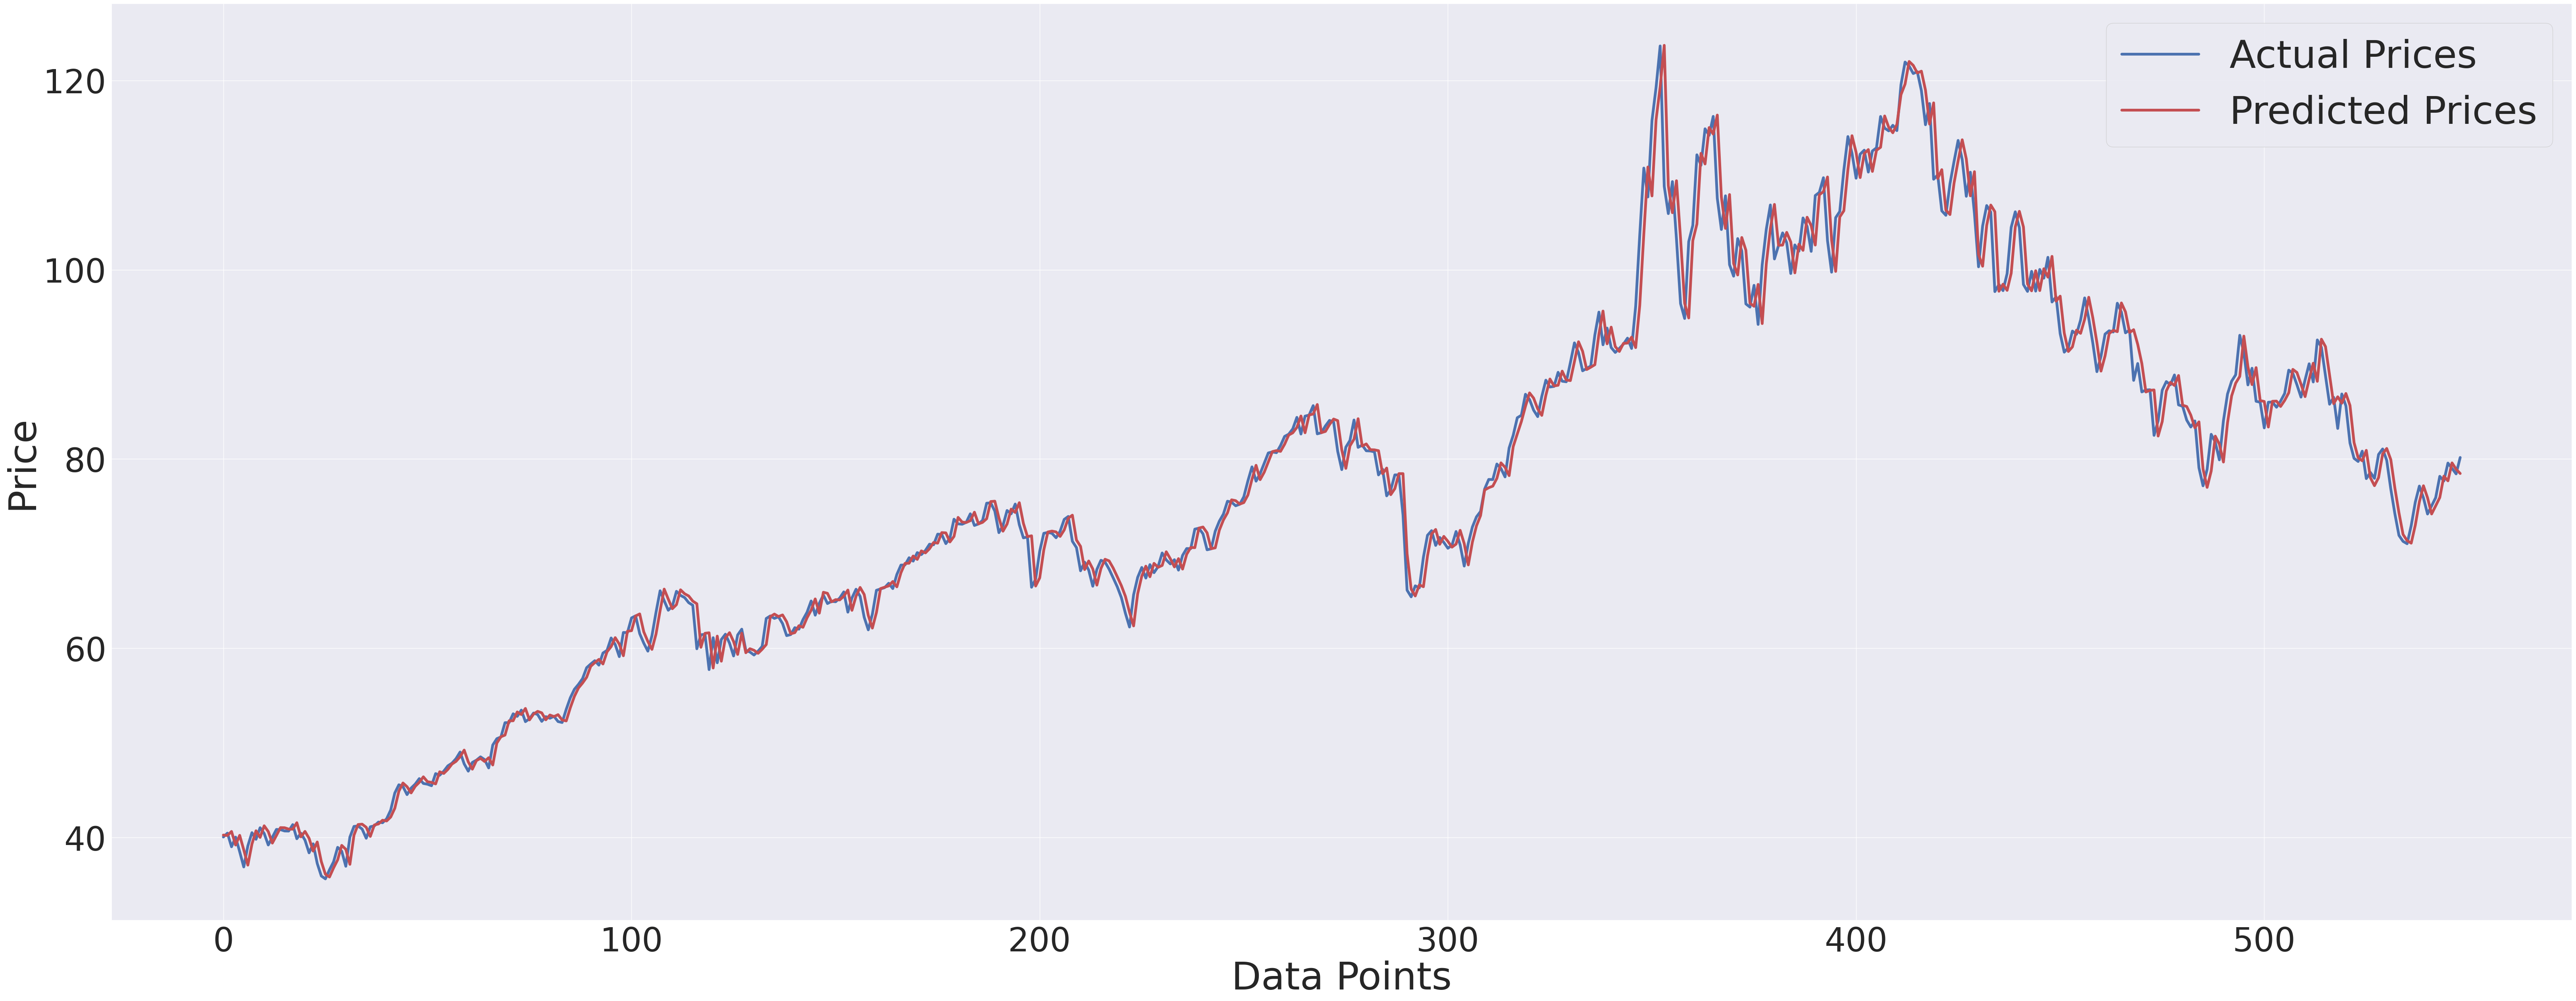

time: 3.83 s (started: 2024-01-07 18:49:52 +00:00)


In [ ]:
plt.figure(figsize=(80, 30))
matplotlib.rc('xtick', labelsize=60)
matplotlib.rc('ytick', labelsize=60)
plt.xlabel('Data Points', fontsize=70)
plt.ylabel('Price', fontsize=70)
plt.plot(df[df.columns[0]], 'b', label='Actual Prices', linewidth=5)
plt.plot(df[df.columns[1]], 'r', label='Predicted Prices', linewidth=5)
plt.legend(fontsize=70)
plt.savefig('test.svg', format='svg')